<a href="https://colab.research.google.com/github/Yuxinn-J/dcgan-PyTorch/blob/main/temp_version0.1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#@title Check GPU {vertical-output: true}
!nvidia-smi -L

print('\nThe above GPU must be a T4, P4, P100, or V100 GPU (K80 will not work, unfortunately)')
print('If the GPU is not valid, please restart the machine until a valid GPU is assigned:')
print('Runtime -> manage sessions -> terminate the session -> start a new session')

GPU 0: Tesla T4 (UUID: GPU-988543e0-c899-315e-bdff-3cbc808cbbaf)

The above GPU must be a T4, P4, P100, or V100 GPU (K80 will not work, unfortunately)
If the GPU is not valid, please restart the machine until a valid GPU is assigned:
Runtime -> manage sessions -> terminate the session -> start a new session


In [1]:
# Pre Installation

import subprocess

CUDA_version = [s for s in subprocess.check_output(["nvcc", "--version"]).decode("UTF-8").split(", ") if s.startswith("release")][0].split(" ")[-1]
print("CUDA version:", CUDA_version)

if CUDA_version == "10.0":
    torch_version_suffix = "+cu100"
elif CUDA_version == "10.1":
    torch_version_suffix = "+cu101"
elif CUDA_version == "10.2":
    torch_version_suffix = "+cu102"
elif CUDA_version == "11.0":
    torch_version_suffix = "+cu110"
elif CUDA_version == "11.1":
    torch_version_suffix = "+cu111"
elif CUDA_version == "11.2":
    torch_version_suffix = "+cu112"
else:
    torch_version_suffix = "+cu110"
# !pip install torch==1.7.1{torch_version_suffix} torchvision==0.8.2{torch_version_suffix} -f https://download.pytorch.org/whl/torch_stable.html &> /dev/null
!pip install --upgrade torch

!pip install ftfy regex tqdm       &> /dev/null

%cd /content/
!pip install svgwrite           &> /dev/null
!pip install svgpathtools       &> /dev/null
!pip install cssutils           &> /dev/null
!pip install numba              &> /dev/null
!pip install torch-tools        &> /dev/null
!pip install visdom             &> /dev/null

!git clone https://github.com/BachiLi/diffvg
%cd diffvg
# !ls
!git submodule update --init --recursive
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)
import sys
sys.path.append("build/lib.linux-x86_64-3.7")
!pip3 install --upgrade Pillow
!python setup.py install           &> /dev/null

CUDA version: 11.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content
fatal: destination path 'diffvg' already exists and is not an empty directory.
/content/diffvg
TensorFlow 1.x selected.
1.15.2
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!wget 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth'

--2022-05-27 04:47:22--  https://download.pytorch.org/models/vgg19-dcbb9e9d.pth
Resolving download.pytorch.org (download.pytorch.org)... 13.32.208.57, 13.32.208.73, 13.32.208.46, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.32.208.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 574673361 (548M) [binary/octet-stream]
Saving to: ‘vgg19-dcbb9e9d.pth’

vgg19-dcbb9e9d.pth  100%[===================>] 548.05M  90.0MB/s    in 6.6s    

2022-05-27 04:47:28 (83.6 MB/s) - ‘vgg19-dcbb9e9d.pth’ saved [574673361/574673361]



In [4]:
#@title Imports and Notebook Utilities {vertical-output: true}
%tensorflow_version 2.x

import os
import io
import PIL.Image, PIL.ImageDraw
import base64
import zipfile
import json
import requests
import numpy as np
import matplotlib.pylab as pl
import glob
import copy 
from tqdm import tqdm

from IPython.display import Image, HTML, clear_output
from tqdm import tqdm_notebook, tnrange

os.environ['FFMPEG_BINARY'] = 'ffmpeg'
import moviepy.editor as mvp
from moviepy.video.io.ffmpeg_writer import FFMPEG_VideoWriter


def imread(url, max_size=None, mode=None):
  if url.startswith(('http:', 'https:')):
    r = requests.get(url)
    f = io.BytesIO(r.content)
  else:
    f = url
  img = PIL.Image.open(f)
  if max_size is not None:
    img = img.resize((max_size, max_size))
  if mode is not None:
    img = img.convert(mode)
  img = np.float32(img)/255.0
  return img

def np2pil(a):
  if a.dtype in [np.float32, np.float64]:
    a = np.uint8(np.clip(a, 0, 1)*255)
  return PIL.Image.fromarray(a)

def imwrite(f, a, fmt=None):
  a = np.asarray(a)
  if isinstance(f, str):
    fmt = f.rsplit('.', 1)[-1].lower()
    if fmt == 'jpg':
      fmt = 'jpeg'
    f = open(f, 'wb')
  np2pil(a).save(f, fmt, quality=95)

def imencode(a, fmt='jpeg'):
  a = np.asarray(a)
  if len(a.shape) == 3 and a.shape[-1] == 4:
    fmt = 'png'
  f = io.BytesIO()
  imwrite(f, a, fmt)
  return f.getvalue()

def im2url(a, fmt='jpeg'):
  encoded = imencode(a, fmt)
  base64_byte_string = base64.b64encode(encoded).decode('ascii')
  return 'data:image/' + fmt.upper() + ';base64,' + base64_byte_string

def imshow(a, fmt='jpeg'):
  display(Image(data=imencode(a, fmt)))


def tile2d(a, w=None):
  a = np.asarray(a)
  if w is None:
    w = int(np.ceil(np.sqrt(len(a))))
  th, tw = a.shape[1:3]
  pad = (w-len(a))%w
  a = np.pad(a, [(0, pad)]+[(0, 0)]*(a.ndim-1), 'constant')
  h = len(a)//w
  a = a.reshape([h, w]+list(a.shape[1:]))
  a = np.rollaxis(a, 2, 1).reshape([th*h, tw*w]+list(a.shape[4:]))
  return a

from torchvision import utils
def show_img(img):
    img = np.transpose(img, (1, 2, 0))
    img = np.clip(img, 0, 1)
    img = np.uint8(img * 254)
    # img = np.repeat(img, 4, axis=0)
    # img = np.repeat(img, 4, axis=1)
    pimg = PIL.Image.fromarray(img, mode="RGB")
    imshow(pimg)

def zoom(img, scale=4):
  img = np.repeat(img, scale, 0)
  img = np.repeat(img, scale, 1)
  return img

class VideoWriter:
  def __init__(self, filename='_autoplay.mp4', fps=30.0, **kw):
    self.writer = None
    self.params = dict(filename=filename, fps=fps, **kw)

  def add(self, img):
    img = np.asarray(img)
    if self.writer is None:
      h, w = img.shape[:2]
      self.writer = FFMPEG_VideoWriter(size=(w, h), **self.params)
    if img.dtype in [np.float32, np.float64]:
      img = np.uint8(img.clip(0, 1)*255)
    if len(img.shape) == 2:
      img = np.repeat(img[..., None], 3, -1)
    self.writer.write_frame(img)

  def close(self):
    if self.writer:
      self.writer.close()

  def __enter__(self):
    return self

  def __exit__(self, *kw):
    self.close()
    if self.params['filename'] == '_autoplay.mp4':
      self.show()

  def show(self, **kw):
      self.close()
      fn = self.params['filename']
      display(mvp.ipython_display(fn, **kw))


import torch

# torch.set_default_tensor_type('torch.cuda.FloatTensor')
# print("Torch version:", torch.__version__)

import pydiffvg
import skimage
import skimage.io
import random
import ttools.modules
import argparse
import math
import torchvision
import torchvision.transforms as transforms
import requests
from io import BytesIO


import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import PIL
from time import time

device = torch.device('cuda')


pydiffvg.set_print_timing(False)
# Use GPU if available
pydiffvg.set_use_gpu(torch.cuda.is_available())
pydiffvg.set_device(device)

In [5]:
# Tensor and PIL utils

def pil_loader(path):
    with open(path, 'rb') as f:
        img = PIL.Image.open(f)
        return img.convert('RGB')

def pil_loader_internet(url):
    response = requests.get(url)
    img = PIL.Image.open(BytesIO(response.content))
    return img.convert('RGB')

def tensor_resample(tensor, dst_size, mode='bilinear'):
    return F.interpolate(tensor, dst_size, mode=mode, align_corners=False)

def pil_resize_short_edge_to(pil, trg_size):
    short_w = pil.width < pil.height
    ar_resized_short = (trg_size / pil.width) if short_w else (trg_size / pil.height)
    resized = pil.resize((int(pil.width * ar_resized_short), int(pil.height * ar_resized_short)), PIL.Image.BICUBIC)
    return resized

def pil_resize_long_edge_to(pil, trg_size):
    short_w = pil.width < pil.height
    ar_resized_long = (trg_size / pil.height) if short_w else (trg_size / pil.width)
    resized = pil.resize((int(pil.width * ar_resized_long), int(pil.height * ar_resized_long)), PIL.Image.BICUBIC)
    return resized

def np_to_pil(npy):
    return PIL.Image.fromarray(npy.astype(np.uint8))

def pil_to_np(pil):
    return np.array(pil)

def tensor_to_np(tensor, cut_dim_to_3=True):
    if len(tensor.shape) == 4:
        if cut_dim_to_3:
            tensor = tensor[0]
        else:
            return tensor.data.cpu().numpy().transpose((0, 2, 3, 1))
    return tensor.data.cpu().numpy().transpose((1,2,0))

def np_to_tensor(npy, space):
    if space == 'vgg':
        return np_to_tensor_correct(npy)
    return (torch.Tensor(npy.astype(np.float) / 127.5) - 1.0).permute((2,0,1)).unsqueeze(0)

def np_to_tensor_correct(npy):
    pil = np_to_pil(npy)
    transform = transforms.Compose([transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    return transform(pil).unsqueeze(0)

In [6]:
def render_drawing(shapes, shape_groups,\
                   canvas_width, canvas_height, n_iter, bg_img, save=False):
  
    scene_args = pydiffvg.RenderFunction.serialize_scene(\
        canvas_width, canvas_height, shapes, shape_groups)
    
    render = pydiffvg.RenderFunction.apply
    img = render(canvas_width, canvas_height, 2, 2, n_iter, bg_img, *scene_args)
    img = img[:, :, 3:4] * img[:, :, :3] + torch.ones(img.shape[0], img.shape[1], 3, device = pydiffvg.get_device()) * (1 - img[:, :, 3:4])        
    if save:
        pydiffvg.imwrite(img.cpu(), '/content/res/iter_{}.png'.format(int(n_iter)), gamma=1.0)
    img = img[:, :, :3]
    img = img.unsqueeze(0)
    img = img.permute(0, 3, 1, 2) # NHWC -> NCHW
    return img

def render_scaled(shapes, shape_groups, bg_img, original_height, original_width, 
                  scale_factor=4, t=1):
    '''
        Scale the size of the rendered image
    '''
    with torch.no_grad():
        shapes_resized = copy.deepcopy(shapes)
        for i in range(len(shapes)):
            shapes_resized[i].stroke_width = shapes[i].stroke_width * scale_factor
            for j in range(len(shapes[i].points)):
                shapes_resized[i].points[j] = shapes[i].points[j] * scale_factor
        img = render_drawing(shapes_resized, shape_groups, bg_img,
                             int(original_width*scale_factor), int(original_height*scale_factor), t)
        return img

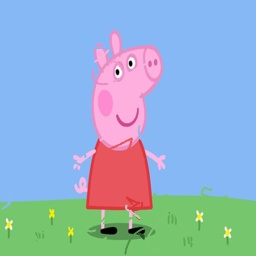

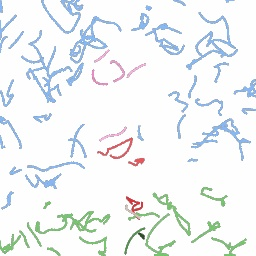

In [7]:
import math

def initialize_curves_col(num_paths, canvas_width, canvas_height, bg):
    shapes = []
    shape_groups = []
    for i in range(num_paths):
        num_segments = random.randint(1, 3)
        num_control_points = torch.zeros(num_segments, dtype = torch.int32) + 2
        points = []
        p0 = (random.random(), random.random())
        points.append(p0)
        for j in range(num_segments):
            radius = 0.1
            p1 = (p0[0] + radius * (random.random() - 0.5), p0[1] + radius * (random.random() - 0.5))
            p2 = (p1[0] + radius * (random.random() - 0.5), p1[1] + radius * (random.random() - 0.5))
            p3 = (p2[0] + radius * (random.random() - 0.5), p2[1] + radius * (random.random() - 0.5))
            points.append(p1)
            points.append(p2)
            points.append(p3)
            p0 = p3
        points = torch.tensor(points)
        points[:, 0] *= canvas_width
        points[:, 0].clamp_(0, canvas_width-1)
        points[:, 1] *= canvas_height
        points[:, 1].clamp_(0, canvas_height-1)

        path = pydiffvg.Path(num_control_points = num_control_points, points = points, stroke_width = torch.tensor(1.0), is_closed = False)
        shapes.append(path)

        # where t = 0.5, the mid point of the curve
        mid_x = round((points[0][0] + 3 * points[1][0] + 3 * points[2][0] + points[3][0]).item() / 8)
        mid_y = round((points[0][1] + 3 * points[1][1] + 3 * points[2][1] + points[3][1]).item() / 8)

        # seems need transpose
        R = bg[mid_y][mid_x][0]
        G = bg[mid_y][mid_x][1]
        B = bg[mid_y][mid_x][2]

        stroke_color = torch.tensor([R, G, B, 1.0])

        path_group = pydiffvg.ShapeGroup(shape_ids = torch.tensor([len(shapes) - 1]), fill_color = None, stroke_color = stroke_color)
        shape_groups.append(path_group)

    return shapes, shape_groups

def np_to_tensor_bg(npy, space):
    return (torch.Tensor(npy.astype(np.float) / 127.5) - 1.0).permute((0,1,2))

content_path = 'https://i.guim.co.uk/img/media/c8b1d78883dfbe7cd3f112495941ebc0b25d2265/256_0_3840_2304/master/3840.jpg?width=620&quality=85&auto=format&fit=max&s=7cc0c075c4202330b5d4ca6d4d825277'

num_paths = 100
size = 256
canvas_width = size
canvas_height = size

content_pil = pil_loader(content_path) if os.path.exists(content_path) else pil_loader_internet(content_path)
content_pil = content_pil.resize((size, size), PIL.Image.BICUBIC)
content_np = pil_to_np(content_pil)
bg = (np_to_tensor_bg(content_np, "normal").to(device)+1)/2

# Initialize Random Curves
shapes, shape_groups = initialize_curves_col(num_paths, canvas_width, canvas_height, bg)

img = render_drawing(shapes, shape_groups, canvas_width, canvas_height, 0, bg, save=False)
draw = render_drawing(shapes, shape_groups, canvas_width, canvas_height, 0, None, save=False)

show_img(img.detach().cpu().numpy()[0])
show_img(draw.detach().cpu().numpy()[0])

In [13]:
class Vgg16(nn.Module):
    def __init__(self):
        super(Vgg16, self).__init__()
        features = models.vgg16(pretrained=True).features
        self.to_relu_1_2 = nn.Sequential() 
        self.to_relu_2_2 = nn.Sequential() 
        self.to_relu_3_3 = nn.Sequential()
        self.to_relu_4_3 = nn.Sequential()

        for x in range(4):
            self.to_relu_1_2.add_module(str(x), features[x])
        for x in range(4, 9):
            self.to_relu_2_2.add_module(str(x), features[x])
        for x in range(9, 16):
            self.to_relu_3_3.add_module(str(x), features[x])
        for x in range(16, 23):
            self.to_relu_4_3.add_module(str(x), features[x])
        
        # don't need the gradients, just want the features
        for param in self.parameters():
            param.requires_grad = False

    def forward(self, x):
        h = self.to_relu_1_2(x)
        h_relu_1_2 = h
        h = self.to_relu_2_2(h)
        h_relu_2_2 = h
        h = self.to_relu_3_3(h)
        h_relu_3_3 = h
        h = self.to_relu_4_3(h)
        h_relu_4_3 = h
        out = (h_relu_1_2, h_relu_2_2, h_relu_3_3, h_relu_4_3)
        return out

In [9]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [12]:
from google.colab import files


def np_to_tensor_bg(npy, space):
    return (torch.Tensor(npy.astype(np.float) / 127.5) - 1.0).permute((0,1,2))


def style_clip_draw(content_path, smooth_path, style_path, \
                    num_paths=500, max_width=10,\
                    debug=False):
    '''
    Perform StyleCLIPDraw using a given text prompt and style image. Fast version.
    args:
        style_path(str) : Style image path or url
    kwargs:
        num_paths (int) : Number of brush strokes
        max_width(float) : Maximum width of a brush stroke in pixels
        debug(bool) : Print intermediate canvases and losses for debugging
    return
        np.ndarray(canvas_height, canvas_width, 3)
    '''
    # Load Images
    SIZE = 512
    canvas_width, canvas_height = SIZE, SIZE

    content_pil = pil_loader(content_path) if os.path.exists(content_path) else pil_loader_internet(content_path)
    content_pil = content_pil.resize((SIZE, SIZE), PIL.Image.BICUBIC)
    content_np = pil_to_np(content_pil)
    content = (np_to_tensor(content_np, "normal").to(device)+1)/2
    #bg = (np_to_tensor_bg(content_np, "normal").to(device)+1)/2

    smooth_pil = pil_loader(smooth_path) if os.path.exists(smooth_path) else pil_loader_internet(smooth_path)
    smooth_pil = smooth_pil.resize((SIZE, SIZE), PIL.Image.BICUBIC)
    smooth_np = pil_to_np(smooth_pil)
    bg = (np_to_tensor_bg(smooth_np, "normal").to(device)+1)/2

    style_pil = pil_loader(style_path) if os.path.exists(style_path) else pil_loader_internet(style_path)
    style_pil = style_pil.resize((SIZE, SIZE), PIL.Image.BICUBIC)
    style_np = pil_to_np(style_pil)
    style = (np_to_tensor(style_np, "normal").to(device)+1)/2

    # Initialize Random Curves
    shapes, shape_groups = initialize_curves_col(num_paths, canvas_width, canvas_height, bg)

    points_vars = []
    stroke_width_vars = []
    color_vars = []
    for path in shapes:
        path.points.requires_grad = True
        points_vars.append(path.points)
        path.stroke_width.requires_grad = True
        stroke_width_vars.append(path.stroke_width)
    for group in shape_groups:
        #group.stroke_color[0:3].requires_grad = True
        # Fixed transparency
        #group.stroke_color[3].requires_grad = False
        #color_vars.append(group.stroke_color[0:3])
        group.stroke_color.requires_grad = True
        color_vars.append(group.stroke_color)

    # Optimizers
    points_optim_style = torch.optim.RMSprop(points_vars, lr=0.1*3)
    width_optim_style = torch.optim.RMSprop(stroke_width_vars, lr=0.1*3)
    color_optim_style = torch.optim.RMSprop(color_vars, lr=0.001*3)

    # Loss
    MSE_loss = nn.MSELoss().to(device)
    L1_loss = nn.L1Loss().to(device)

    # Network
    vgg_model = 'vgg19-dcbb9e9d.pth'
    VGG = VGG19(init_weights=vgg_model, feature_mode=True)
    VGG.to(device)
    VGG.eval()

    # Extract content features from content image
    content_feature = VGG((content + 1) / 2)

    # Extract style features from style image
    style_feature = VGG((style + 1) / 2)
    
    #best_content_loss, its_since_best = 9999999, 0
    
    # Run the main optimization loop
    # for t in range(num_iter) if debug else tqdm(range(num_iter)):
    t = 0
    num_iter=1000
    pbar = tqdm(total=num_iter)
    while(t < num_iter):
        # for g in points_optim_style.param_groups + width_optim_style.param_groups + color_optim_style.param_groups:
        #     g['lr'] *= 0.98

        points_optim_style.zero_grad()
        width_optim_style.zero_grad()
        color_optim_style.zero_grad()

        img = render_drawing(shapes, shape_groups, canvas_width, canvas_height, t, bg, save=(t % 5 == 0))
        draw = render_drawing(shapes, shape_groups, canvas_width, canvas_height, t, None, save=(t % 5 == 0))
        loss = 0

        # Do style optimization 
        output_feature = VGG((img + 1) / 2)

        content_loss = 10 * MSE_loss(output_feature, content_feature.detach())
        style_loss = 10000 * L1_loss(gram_matrix(output_feature), gram_matrix(style_feature).detach())
       
        loss += style_loss + content_loss
        
        
        loss.backward()
        #style_loss.backward(retain_graph=True)
        points_optim_style.step()
        width_optim_style.step()
        color_optim_style.step()
        for path in shapes:
            path.stroke_width.data.clamp_(1.0, max_width)
        for group in shape_groups:
            #group.stroke_color[0:3].data.clamp_(0.0, 1.0)
            group.stroke_color.data.clamp_(0.0, 1.0)

        t += 1
        pbar.update(1)

        if t % 20 == 0 or t == 1:
            draw = render_drawing(shapes, shape_groups, canvas_width, canvas_height, t, None, save=True)
            img = render_drawing(shapes, shape_groups, canvas_width, canvas_height, t, bg, save=True)
            show_img(img.detach().cpu().numpy()[0])
            show_img(draw.detach().cpu().numpy()[0])
            print('render loss:', loss.item())
            print('content loss:', content_loss)
            print('style loss:', style_loss)
            #print('pix loss:', pix_loss)
            print('iteration:', t)
    pbar.close()
    return render_drawing(shapes, shape_groups, canvas_width, canvas_height, t, bg).detach().cpu().numpy()[0]



  0%|          | 1/1000 [00:02<35:11,  2.11s/it]

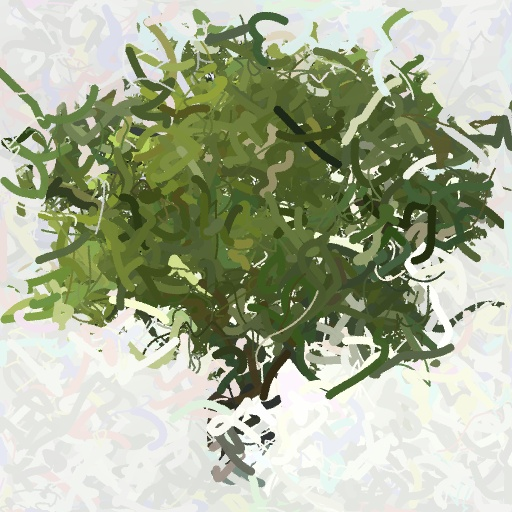

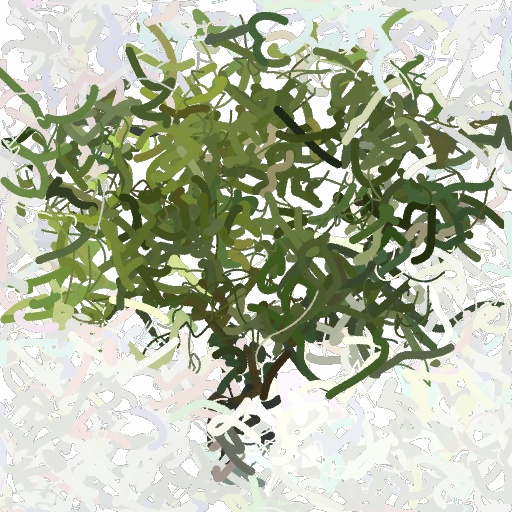

render loss: 175.97203063964844
content loss: tensor(66.3016, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(109.6704, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 1


  2%|▏         | 20/1000 [00:34<26:16,  1.61s/it]

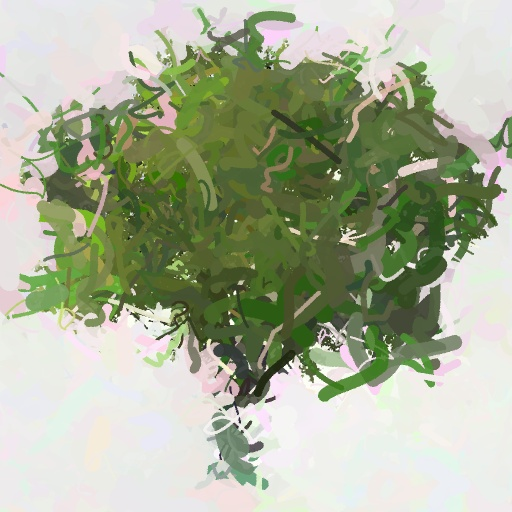

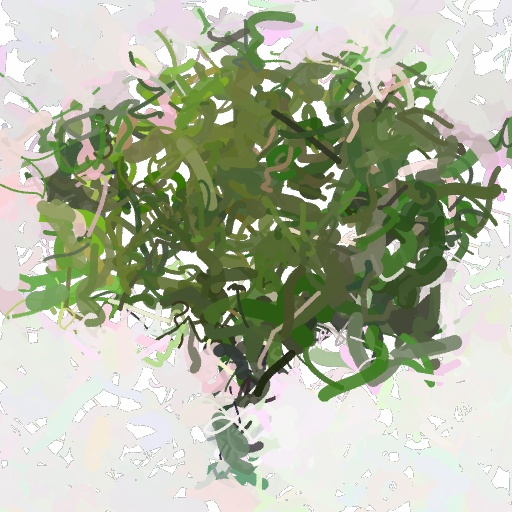

render loss: 75.77106475830078
content loss: tensor(45.5781, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(30.1930, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 20


  4%|▍         | 40/1000 [01:09<26:08,  1.63s/it]

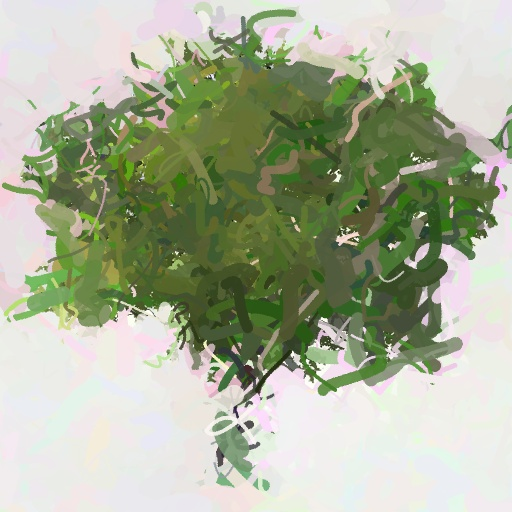

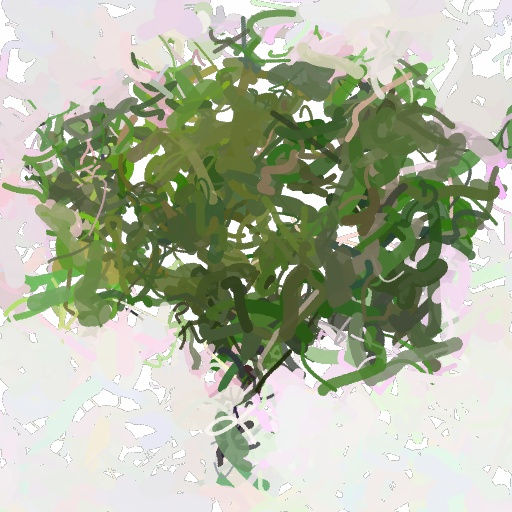

render loss: 68.4516372680664
content loss: tensor(41.5784, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(26.8733, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 40


  6%|▌         | 60/1000 [01:45<25:47,  1.65s/it]

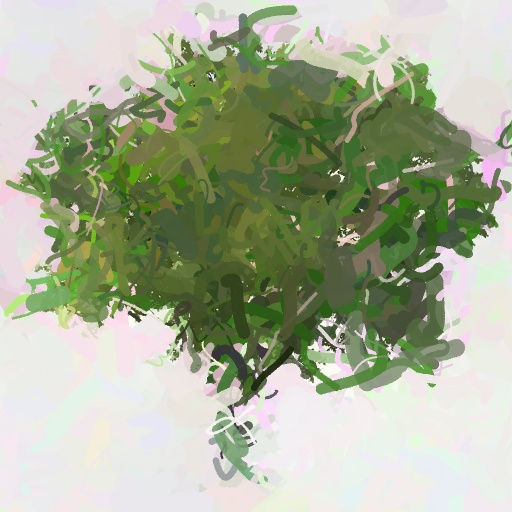

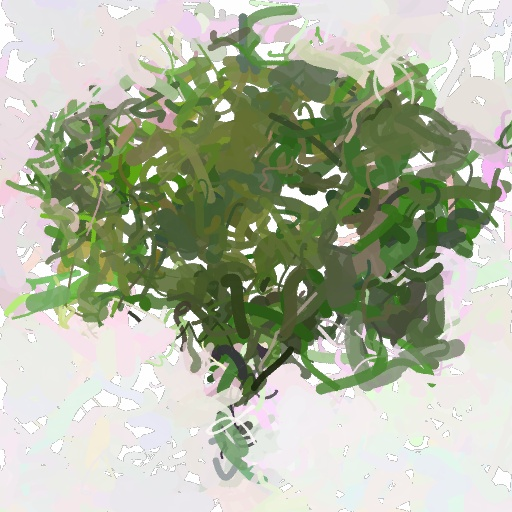

render loss: 65.7270278930664
content loss: tensor(39.7299, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(25.9971, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 60


  8%|▊         | 80/1000 [02:22<25:23,  1.66s/it]

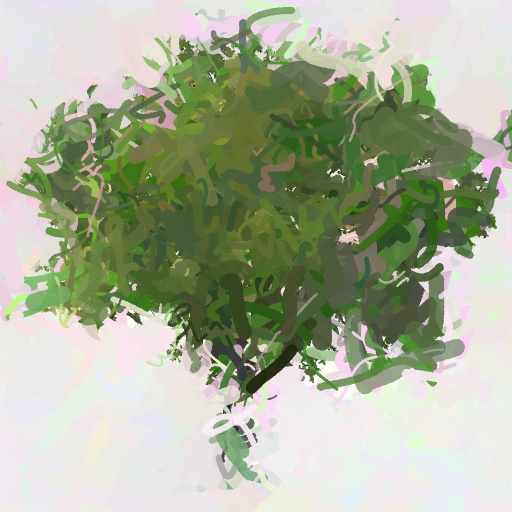

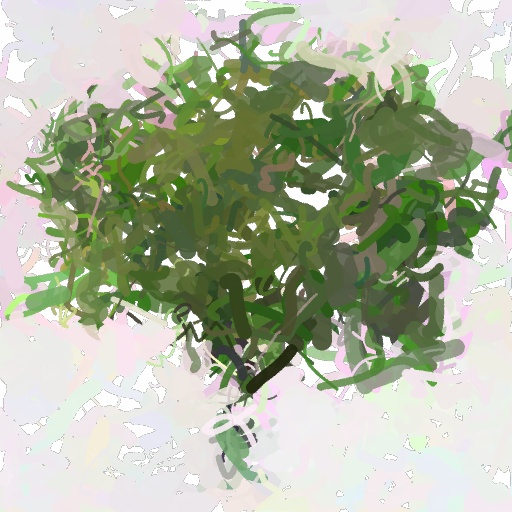

render loss: 58.59058380126953
content loss: tensor(37.9000, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(20.6906, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 80


 10%|█         | 100/1000 [02:59<25:27,  1.70s/it]

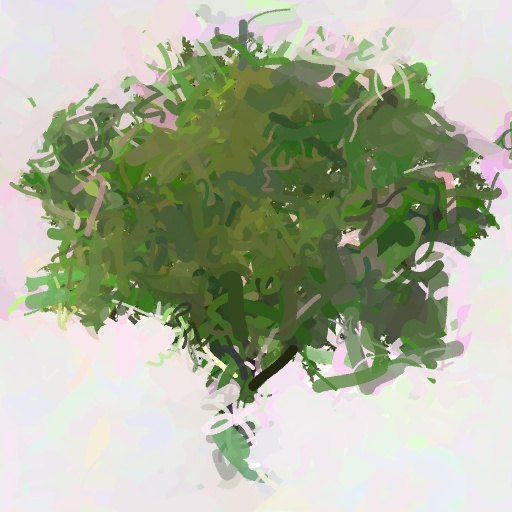

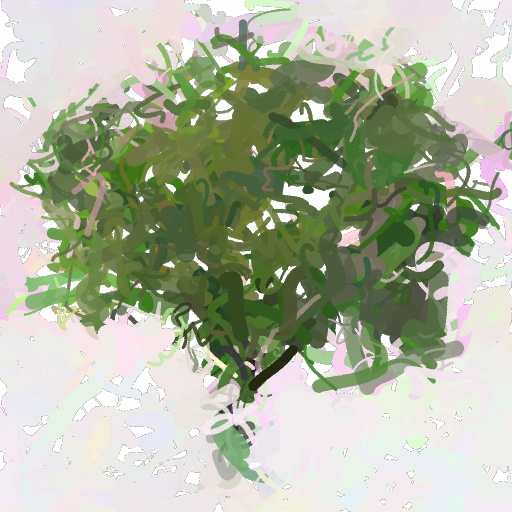

render loss: 59.16495895385742
content loss: tensor(37.4387, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(21.7263, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 100


 12%|█▏        | 120/1000 [03:36<24:50,  1.69s/it]

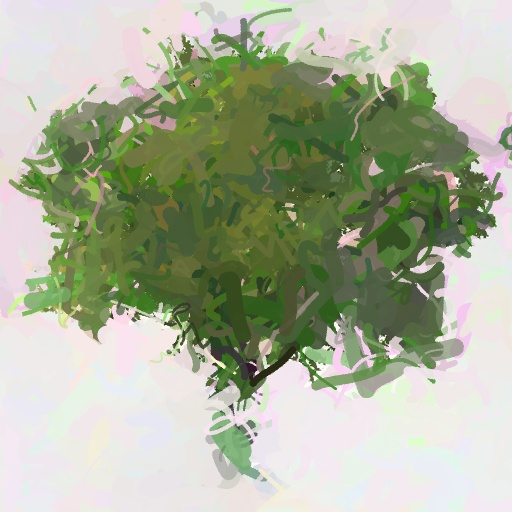

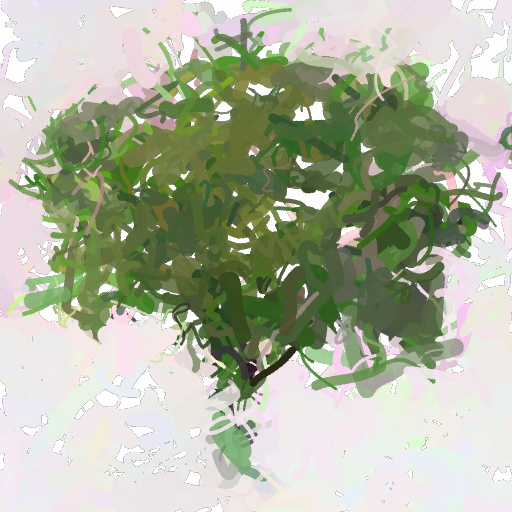

render loss: 55.754920959472656
content loss: tensor(36.0246, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(19.7303, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 120


 14%|█▍        | 140/1000 [04:13<24:35,  1.72s/it]

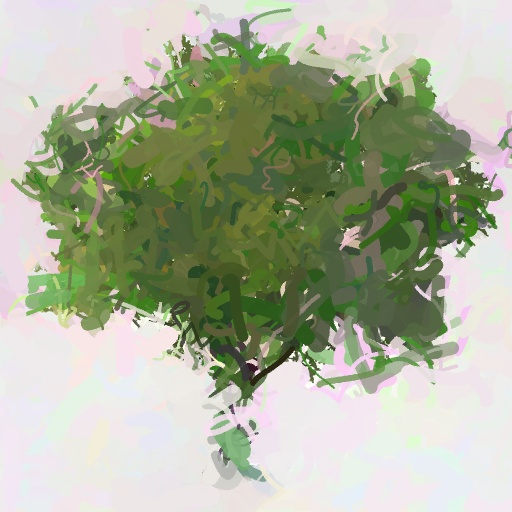

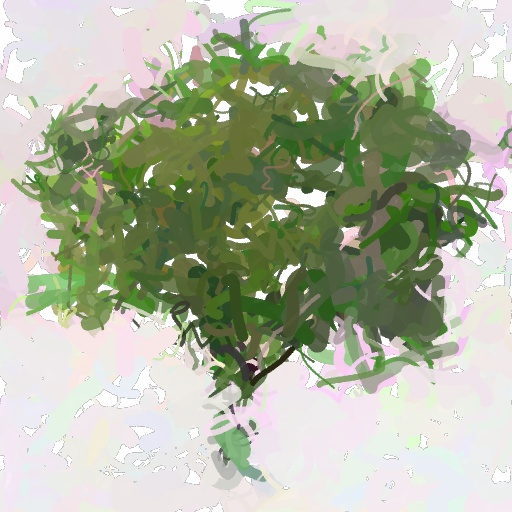

render loss: 56.11866760253906
content loss: tensor(35.8236, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(20.2951, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 140


 16%|█▌        | 160/1000 [04:50<23:59,  1.71s/it]

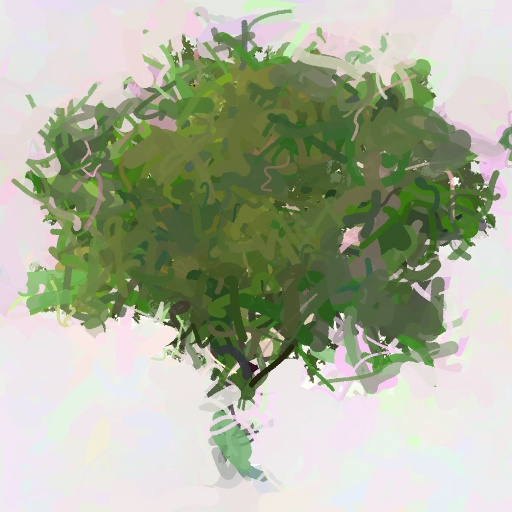

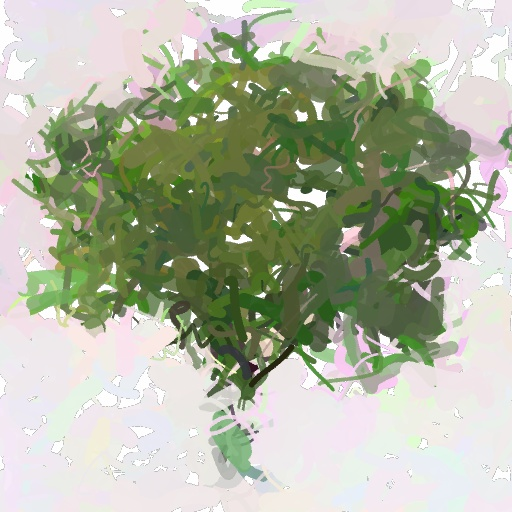

render loss: 52.41300582885742
content loss: tensor(34.6799, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(17.7331, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 160


 18%|█▊        | 180/1000 [05:28<23:32,  1.72s/it]

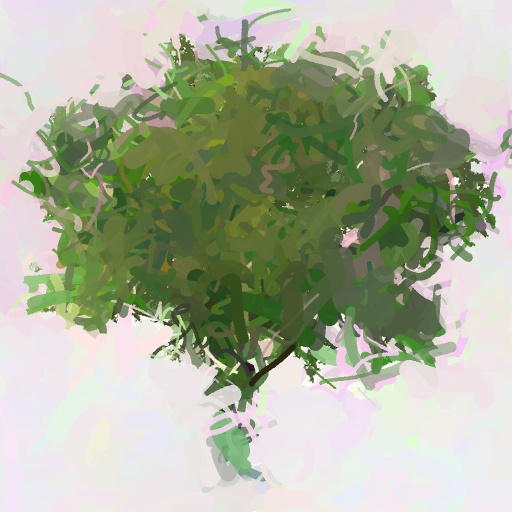

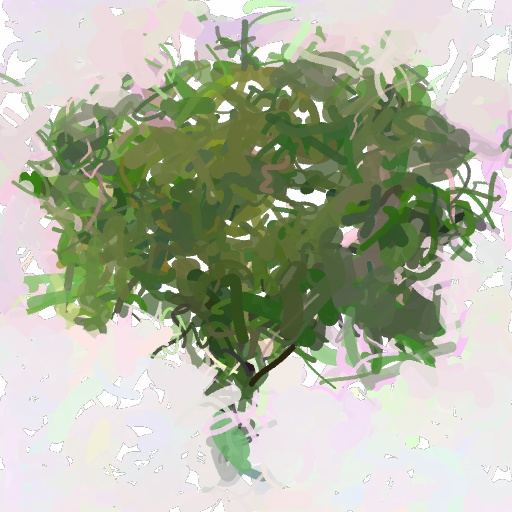

render loss: 48.602848052978516
content loss: tensor(33.8889, device='cuda:0', grad_fn=<MulBackward0>)
style loss: tensor(14.7140, device='cuda:0', grad_fn=<MulBackward0>)
iteration: 180


KeyboardInterrupt: ignored

In [11]:
#content_p = 'https://wallpaperaccess.com/full/2117773.jpg'
content_p = 'https://dynamicbikecare.com/wp-content/uploads/2022/04/Dynamic_tree_green_week.jpeg'
#content_p = 'https://image.shutterstock.com/image-illustration/cloud-anime-painting-style-on-260nw-1538501684.jpg'

smooth_p = 'Dynamic_tree_green_week_1.png'
#style_p = 'https://c4.wallpaperflare.com/wallpaper/555/569/194/movie-pokemon-the-movie-2000-pidgey-pokemon-wallpaper-preview.jpg'
# tree
style_p = 'https://cdna.artstation.com/p/marketplace/presentation_assets/000/113/804/large/file.png?1553142298'
#style_p = 'https://raw.githubusercontent.com/cysmith/neural-style-tf/master/examples/lions/styles/wave_crop.jpg'

img = style_clip_draw(content_p, smooth_p, style_p)
show_img(img)